<html>
<table width="100%" cellspacing="2" cellpadding="2" border="1">
<tbody>
<tr>
<td valign="center" align="center" width="25%"><img src="../../media/decartes.jpg"
alt="DeCART Icon" width="128" height="171"><br>
</td>
<td valign="center" align="center" width="75%">
<h1 align="center"><font size="+3">DeCART Summer School<br>
for<br>
Biomedical Data Science</font></h1></td>
<td valign="center" align="center" width="25%"><img
src="../../media/U_Health_stacked_png_red.png" alt="Utah Health
Logo" width="128" height="134"><br>
</td>
</tr>
</tbody>
</table>
<br>
</html>


# Working with Textual Data
#### &copy; Brian E. Chapman, Ph.D.


### To get the latest version of this lesson, execute the cell below

In [1]:
%matplotlib inline

In [19]:
import pymysql
import pandas as pd
import getpass
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [3]:
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd=getpass.getpass("Enter MySQL passwd for jovyan"),db='mimic2')
cursor = conn.cursor()

Enter MySQL passwd for jovyan········


### Use Pandas and SQL to create a dataframe with the following:
* subject_id
* hospital admission id
* text of the radiology report
* Limit the number of reports to 10000

In [23]:
rad_data = \
pd.read_sql("""SELECT noteevents.subject_id, 
                      noteevents.hadm_id,
                      noteevents.text 
               FROM noteevents
               WHERE noteevents.category = 'RADIOLOGY_REPORT'""",conn)
rad_data.head(5)

,subject_id,hadm_id,text
0,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
1,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
2,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...
3,56,28766.0,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...
4,56,28766.0,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...


In [5]:
print(rad_data["text"][0])




     DATE: [**2644-1-17**] 10:53 AM
     MR HEAD W & W/O CONTRAST; MR CONTRAST GADOLIN                   Clip # [**Clip Number (Radiology) 12569**]
     Reason: R ICB and HX brain mets - eval - also with DWI for CVA Do MR
      Contrast: MAGNEVIST Amt: 15
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
      [**Age over 90 **] year old woman with lung CA- mets to brain                                   
     REASON FOR THIS EXAMINATION:
      R ICB and HX brain mets - eval - also with DWI for CVA Do MRI both with and 
      without contast please
     ______________________________________________________________________________
                                     FINAL REPORT
     EXAMINATION:  MRI of the brain with and without gadolinium.
     
     INDICATION:  [**Age over 90 **] year old woman with lung cancer and right intracranial bleed
     and history of brain metastases.  Please evaluate for acute infar

## Section Splitting

<img src="http://medicine.utah.edu/dbmi/images/faculty/Chapman,Wendy_240x360.jpg"
alt="Wendy Chapman" width="128">

Clinical reports are often divided into sections. Physicians are taught to write their reports in the SOAP format: subjective information, objective information, assessment, and plan, and sections often reflect this process. Information each setion may be formatted differently. For example, subjective information is often narrative, telling a story of the patient's description of their past medical history and their current issues. The objective section may be much more telegraphic with shortened descriptions of measurements like blood pressure and heart rate, such as "120/80 88". You may need different NLP techniques to accurately extract information out of different sections. Sentence splitting, for example, may be different in subjective versus objective sections. Radiology reports are not in the SOAP format, but section identification can still be very important, because in these reports the radiologist describes what she sees on the radiographic image then sometimes summarizes her impression of what the observations may represent, such as "the infiltrate could be consistent with pneumonia." For some tasks, you may only be interested in the impression, which has more weight than the reasoning that occurs in the Findings section.

## Exercise

Write a function that returns the impression section of a report. The function will take two arguments:

1. The text to search for the impression section is the first positional argument.
1. A list of phrases to use to identify the impression section.

Not every report will have a section labeled "IMPRESSION". You can consider "INTERPRETATION" and "CONCLUSIONS" as synonyms for "IMPRESSION"

If you cannot identify the impresison section (or equivalent), return an empty string.

#### Hints

* Use a for loop  to iterate across
* Use the find method of a string to identify where in the string the impression section occurs
* Use slicing to grab the impression section


In [6]:

def find_impression(report, section= None):
    if section == None:
        section = ["IMPRESSION:", "INTERPRETATION:", "CONCLUSIONS:"]
    for s in section:
        index = report.find(s)
        if index != -1:
            return report[index:].split(s)[1]
    return ""

print(find_impression("This is my report.", section=["not","is"]))
print("*"*42)
#print(rad_data["text"][100])

 
******************************************


## Exercise 

Use ``apply()`` to create a new column in the ``rad_data`` named "IMPRESSIONS" with the string identified with ``find_impression()``.

In [24]:
rad_data.head()
rad_data["IMPRESSION"] = rad_data.apply(lambda  row: find_impression(row["text"]), axis=1)
rad_data.tail()

,subject_id,hadm_id,text,IMPRESSION
65879,32763,33007.0,\n\n\n DATE: [**2724-6-27**] 11:13 AM\n ...,Tiny nonocclusive thrombus in the peripheral...
65880,32763,33007.0,\n\n\n DATE: [**2724-6-29**] 8:28 PM\n ...,
65881,32763,33007.0,\n\n\n DATE: [**2724-6-30**] 11:59 PM\n ...,
65882,32763,33007.0,\n\n\n DATE: [**2724-6-30**] 8:30 PM\n ...,\n 1. No hydronephrosis or mass is noted ...
65883,32763,33007.0,\n\n\n DATE: [**2724-7-8**] 3:38 AM\n ...,AP chest compared to [**6-26**] through 16.\...


In [25]:
print(rad_data["IMPRESSION"][3])


     
     Cardiomegaly and mild CHF.  Nasogastric tube as described above.  Rounded
     opacity overlying the left hilum, which probably representing aspiration
     pneumonia; however, left hilar mass cannot be totally excluded.  Please
     confirm resolution by repeated chest x-ray after treatment, and if the lesion
     persists, please evaluate by CT scan.
     
     The information is communicated with the referring physician, [**Last Name (NamePattern4) 337**]. [**First Name8 (NamePattern2) 12565**] [**Last Name (NamePattern1) 12566**]
     by telephone in the morning of [**2644-1-17**].
                                                                           




## How else might we need to break up a report?

* How would I break a report into sentences?
* How would I break a report into words?

## Group Exercise

### Create a single string with all the reports

#### Hints, etc.
* Use List Comprehension
* Use string joins
* Iterate over the rows of the data frame
* Use TextBlob to get words

In [26]:
rad_data.head()

,subject_id,hadm_id,text,IMPRESSION
0,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,
1,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,
2,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...,Stable appearance of right parietal lobe and...
3,56,28766.0,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...,\n \n Cardiomegaly and mild CHF. Naso...
4,56,28766.0,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...,\n \n Marked improvement in left perih...


In [27]:
imps = [row["IMPRESSION"] for _, row in rad_data.iterrows()]


#### The list comprehension above is equivalent to the following code
```Python
imps = []
for _, row in rad_data.iterrows():
    imps.append(row["IMPRESSION"])
```

In [11]:
imps[2]

'  Stable appearance of right parietal lobe and left thalamic\n     hemorrhages, which are concerning for hemorrhagic metastasis in this patient\n     with known metastatic lung carcinoma to the brain.\n     \n     \n\n'

In [28]:
all_text = " ".join([row["IMPRESSION"] for _, row in rad_data.iterrows()])

In [29]:
for _, row in rad_data[25:35].iterrows():
    print(row["IMPRESSION"])
    print("*"*42)


     
     1.  No abnormal fluid collection or pulmonary infiltrates to explain the
     patient's fever.
     
     2.  Multiple bilateral pulmonary nodules, several of which are slightly more
     prominent than on the prior study.  This may be due to technical differences
     in slice selection.  Attention on follow up studies is recommended.
                                                                 (Over)

     DATE: [**3352-7-16**] 5:21 PM
     CT ABD W&W/O C; CT PELVIS W/CONTRAST                            Clip # [**Clip Number (Radiology) 1635**]
     CT CHEST W/CONTRAST; CT 150CC NONIONIC CONTRAST
     Reason: Pneumonia, free abd fluid.                                  
     Admitting Diagnosis: NON-HODGKIN'S LYMPHOMIA\BONE MARROW TRANSPLANT
      Contrast: OPTIRAY Amt: 150
     ______________________________________________________________________________
                                     FINAL REPORT
     (Cont)
     
     3.  Stable small mesenteric and retroperi

#### Because I got sick of frequent yet meaningless terms, I used some regular expressions to clean up the data

In [30]:
import re
regex_date = re.compile(r"""\[\*\*\d{4,4}-\d{1,2}-\d{1,2}\*\*\]""")
regex_time = re.compile(r"""(\d{1,2}:\d{2,2}( AM|PM)?)""")
regex_clip = re.compile(r"""\[\*\*Clip Number \(Radiology\) \d+\*\*\]""")
regex_final_report = re.compile(r"""_+\s+FINAL REPORT""")
regex_name = re.compile(r"""(\[\*\*(First|Last) Name\d* \(NamePattern\d+\) \d+\*\*\])""")

In [31]:
all_text = regex_date.sub(" ", 
            regex_time.sub(" ", 
             regex_clip.sub(" ",
              regex_final_report.sub(" ",
                regex_name.sub(" ",
                    all_text))))).replace("(Cont)"," ").lower()
all_text = " ". join(TextBlob(all_text).words)

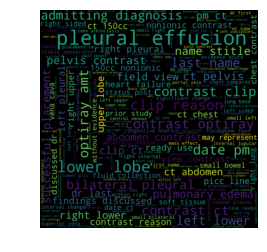

In [32]:
plt.imshow(WordCloud(width=2400, height=2400).generate(all_text),  interpolation='bilinear')
plt.axis("off")
plt.savefig("rad_words.png", dpi=600)